# [Tutorial 06: Classification]()

## [1] Getting Started

### [1a] Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import neighbors
from sklearn import preprocessing
from IPython.display import Markdown, display

### [1b] Plot and Output Settings

In [2]:
# Reset all styles to the default:
plt.rcParams.update(plt.rcParamsDefault)
# Then make graphs inline:
%matplotlib inline

# Useful function for Jupyter to display text in bold:
def displaybd(text):
    display(Markdown("**" + text + "**"))
    
# Set custom style settings:
# NB: We need to separate "matplotlib inline" call and these settings into different
# cells, otherwise the parameters are not set. This is a bug somewhere in Jupyter
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.markersize'] = 10

### [1c] Our Dataset

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,DirectionCode
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1
5,2001,0.213,0.614,-0.623,1.032,0.959,1.3491,1.392,Up,1
6,2001,1.392,0.213,0.614,-0.623,1.032,1.4450,-0.403,Down,0
7,2001,-0.403,1.392,0.213,0.614,-0.623,1.4078,0.027,Up,1
8,2001,0.027,-0.403,1.392,0.213,0.614,1.1640,1.303,Up,1
9,2001,1.303,0.027,-0.403,1.392,0.213,1.2326,0.287,Up,1


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,DirectionCode
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138,0.518400
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334,0.499861
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000,0.000000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500,0.000000
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500,1.000000
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750,1.000000
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000,1.000000


**Correlations matrix:**

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,DirectionCode
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095,0.074608
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155,-0.039757
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250,-0.024081
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448,0.006132
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900,0.004215
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860,0.005423
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592,0.022951
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000,0.730563
DirectionCode,0.074608,-0.039757,-0.024081,0.006132,0.004215,0.005423,0.022951,0.730563,1.000000


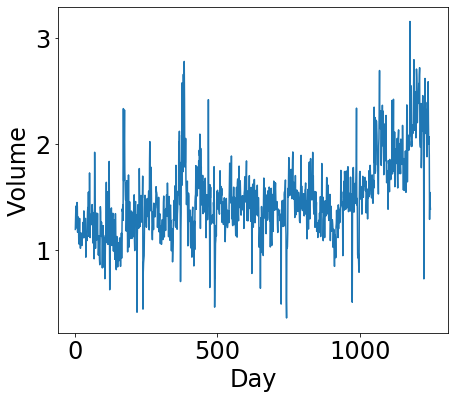

In [3]:
smarket = pd.read_csv('Smarket.csv', parse_dates=False)

# Create direction codes as Up=1 and Down=0 to be sure about the interpretation in regressions:
smarket["DirectionCode"] = np.where(smarket["Direction"].str.contains("Up"), 1, 0)
display(smarket[1:10])

display(smarket.describe())

displaybd("Correlations matrix:")
display(smarket.corr())

smarket["Volume"].plot()
plt.xlabel("Day");
plt.ylabel("Volume");
plt.savefig('smarket.svg', format='svg', dpi=1200, bbox_inches="tight")

## [2] Logit

### [2a] Running Logit via GLM

In [4]:
model = smf.glm("DirectionCode~Lag1+Lag2+Lag3+Lag4+Lag5+Volume", data=smarket,
                family=sm.families.Binomial())
res = model.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          DirectionCode   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Sat, 27 Jun 2020   Deviance:                       1727.6
Time:                        20:46:14   Pearson chi2:                 1.25e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

### [2b] Predicted Probabilities and Confusion Matrix

In [5]:
displaybd("Predicted probabilities for the first observations:")
DirectionProbs = res.predict()
print(DirectionProbs[0:10])

DirectionHat = np.where(DirectionProbs > 0.5, "Up", "Down")
confusionDF = pd.crosstab(DirectionHat, smarket["Direction"],
                          rownames=['Predicted'], colnames=['Actual'],
                          margins=True)
display(Markdown("***"))
displaybd("Confusion matrix:")
display(confusionDF)

displaybd("Share of correctly predicted market movements:")
print(np.mean(smarket['Direction'] == DirectionHat))

**Predicted probabilities for the first observations:**

[0.50708413 0.48146788 0.48113883 0.51522236 0.51078116 0.50695646
 0.49265087 0.50922916 0.51761353 0.48883778]


***

**Confusion matrix:**

Actual,Down,Up,All
Predicted,,,
Down,145,141,286
Up,457,507,964
All,602,648,1250


**Share of correctly predicted market movements:**

0.5216


### [2c] Estimation of Test Error

In [6]:
train = (smarket['Year'] < 2005)
smarket2005 = smarket[~train]
displaybd("Dimensions of the validation set:")
print(smarket2005.shape)

model = smf.glm("DirectionCode~Lag1+Lag2+Lag3+Lag4+Lag5+Volume", data=smarket,
                family=sm.families.Binomial(), subset=train)
res = model.fit()

DirectionProbsTets = res.predict(smarket2005)
DirectionTestHat = np.where(DirectionProbsTets > 0.5, "Up", "Down")
displaybd("Share of correctly predicted market movements in 2005:")
print(np.mean(smarket2005['Direction'] == DirectionTestHat))

**Dimensions of the validation set:**

(252, 10)


**Share of correctly predicted market movements in 2005:**

0.4801587301587302


## [3] Linear Discriminant Analysis

### [3a] Custom Output Functions

In [7]:
def printPriorProbabilities(ldaClasses, ldaPriors):
    priorsDF = pd.DataFrame()
    for cIdx, cName in enumerate(ldaClasses):
        priorsDF[cName] = [ldaPriors[cIdx]];
    displaybd('Prior probablities of groups:')
    display(Markdown(priorsDF.to_html(index=False)))
    
def printGroupMeans(ldaClasses, featuresNames, ldaGroupMeans):
    displaybd("Group means:")
    groupMeansDF = pd.DataFrame(index=ldaClasses)
    for fIdx, fName in enumerate(featuresNames):
         groupMeansDF[fName] = ldaGroupMeans[:, fIdx]
    display(groupMeansDF)

def printLDACoeffs(featuresNames, ldaCoeffs):
    coeffDF = pd.DataFrame(index=featuresNames)
    for cIdx in range(ldaCoeffs.shape[0]):
        colName = "LDA" + str(cIdx + 1)
        coeffDF[colName] = ldaCoeffs[cIdx]
    displaybd("Coefficients of linear discriminants:")
    display(coeffDF)

### [3b] Fitting an LDA Model

In [21]:
outcomeName = 'Direction'
featuresNames = ['Lag1', 'Lag2'];

X_train = smarket.loc[train, featuresNames]
y_train = smarket.loc[train, outcomeName]

lda = LinearDiscriminantAnalysis()
ldaFit = lda.fit(X_train, y_train);

printPriorProbabilities(ldaFit.classes_, ldaFit.priors_)
printGroupMeans(ldaFit.classes_, featuresNames, ldaFit.means_)
printLDACoeffs(featuresNames, ldaFit.coef_)
# Coefficients calcualted by Python's LDA are different from R's lda.
# But they are proportional:
printLDACoeffs(featuresNames, 11.580267503964166 * ldaFit.coef_)
# See this: https://stats.stackexchange.com/questions/87479/what-are-coefficients-of-linear-discriminants-in-lda

**Prior probablities of groups:**

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Down</th>
      <th>Up</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.491984</td>
      <td>0.508016</td>
    </tr>
  </tbody>
</table>

**Group means:**

,Lag1,Lag2
Down,0.042790,0.033894
Up,-0.039546,-0.031325


**Coefficients of linear discriminants:**

,LDA1
Lag1,-0.055441
Lag2,-0.044345


**Coefficients of linear discriminants:**

,LDA1
Lag1,-0.642019
Lag2,-0.513529


### [3c] LDA Predictions

In [9]:
X_test = smarket2005.loc[~train, featuresNames]
y_test = smarket.loc[~train, outcomeName]
y_hat = ldaFit.predict(X_test)

confusionDF = pd.crosstab(y_hat, y_test,
                          rownames=['Predicted'], colnames=['Actual'],
                          margins=True)
displaybd("Confusion matrix:")
display(confusionDF)

displaybd("Share of correctly predicted market movements:")
print(np.mean(y_test == y_hat))

**Confusion matrix:**

Actual,Down,Up,All
Predicted,,,
Down,35,35,70
Up,76,106,182
All,111,141,252


**Share of correctly predicted market movements:**

0.5595238095238095


### [3d] Posterior Probabilities

In [10]:
pred_p = lda.predict_proba(X_test)
# pred_p is an array of shape (number of observations) x (number of classes)

upNmb = np.sum(pred_p[:, 1] > 0.5)
displaybd("Number of upward movements with threshold 0.5: " + str(upNmb))

upNmb = np.sum(pred_p[:, 1] > 0.9)
displaybd("Number of upward movements with threshold 0.9: " + str(upNmb))

**Number of upward movements with threshold 0.5: 182**

**Number of upward movements with threshold 0.9: 0**

## [4] Quadratic Discriminant Analysis

### [4a] Fitting a QDA Model

In [11]:
qda = QuadraticDiscriminantAnalysis()
qdaFit = qda.fit(X_train, y_train);
printPriorProbabilities(qdaFit.classes_, qdaFit.priors_)
printGroupMeans(qdaFit.classes_, featuresNames, qdaFit.means_)

**Prior probablities of groups:**

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Down</th>
      <th>Up</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.491984</td>
      <td>0.508016</td>
    </tr>
  </tbody>
</table>

**Group means:**

,Lag1,Lag2
Down,0.042790,0.033894
Up,-0.039546,-0.031325


### [4b] QDA Predictions

In [12]:
y_hat = qdaFit.predict(X_test)
confusionDF = pd.crosstab(y_hat, y_test,
                          rownames=['Predicted'], colnames=['Actual'],
                          margins=True)
displaybd("Confusion matrix:")
display(confusionDF)
displaybd("Share of correctly predicted market movements:")
print(np.mean(y_test == y_hat))

**Confusion matrix:**

Actual,Down,Up,All
Predicted,,,
Down,30,20,50
Up,81,121,202
All,111,141,252


**Share of correctly predicted market movements:**

0.5992063492063492


## [5] k-Nearest Neighbors

### [5a] One Neighbor

In [13]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
y_hat = knn.fit(X_train, y_train).predict(X_test)
confusionDF = pd.crosstab(y_hat, y_test,
                          rownames=['Predicted'], colnames=['Actual'],
                          margins=True)
displaybd("Confusion matrix:")
display(confusionDF)
displaybd("Share of correctly predicted market movements:")
print(np.mean(y_test == y_hat))

**Confusion matrix:**

Actual,Down,Up,All
Predicted,,,
Down,43,58,101
Up,68,83,151
All,111,141,252


**Share of correctly predicted market movements:**

0.5


### [5b] Three Neighbors

In [14]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
y_hat = knn.fit(X_train, y_train).predict(X_test)
confusionDF = pd.crosstab(y_hat, y_test,
                          rownames=['Predicted'], colnames=['Actual'],
                          margins=True)
displaybd("Confusion matrix:")
display(confusionDF)
displaybd("Share of correctly predicted market movements:")
print(np.mean(y_test == y_hat))

**Confusion matrix:**

Actual,Down,Up,All
Predicted,,,
Down,48,55,103
Up,63,86,149
All,111,141,252


**Share of correctly predicted market movements:**

0.5317460317460317


## [6] An Application to Caravan Insurance Data

### [6a] A New Dataset

#### [5aa] Loading Our Dataset

In [15]:
caravan = pd.read_csv('Caravan.csv', index_col=0)

display(caravan.describe())
display(caravan.describe(include=[np.object]))

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,...,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,24.253349,1.110615,2.678805,2.991240,5.773617,0.696496,4.626932,1.069907,3.258502,6.183442,...,0.076606,0.005325,0.006527,0.004638,0.570079,0.000515,0.006012,0.031776,0.007901,0.014256
std,12.846706,0.405842,0.789835,0.814589,2.856760,1.003234,1.715843,1.017503,1.597647,1.909482,...,0.377569,0.072782,0.080532,0.077403,0.562058,0.022696,0.081632,0.210986,0.090463,0.119996
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,3.000000,3.000000,7.000000,0.000000,5.000000,1.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,10.000000,5.000000,6.000000,10.000000,9.000000,9.000000,5.000000,9.000000,9.000000,...,8.000000,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,3.000000,2.000000,2.000000


,Purchase
count,5822
unique,2
top,No
freq,5474


#### [6ab] Standardizing Our Data

In [16]:
y = caravan.Purchase
X = caravan.drop('Purchase', axis=1).astype('float64')
X_scaled = preprocessing.scale(X)

#### [6ac] Splitting Data into Train and Test Data

In [17]:
X_train = X_scaled[1000:,:]
y_train = y[1000:]
X_test = X_scaled[:1000,:]
y_test = y[:1000]

### [6b] Using KNN for Prediction

In [18]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
y_hat = knn.fit(X_train, y_train).predict(X_test)
confusionDF = pd.crosstab(y_hat, y_test,
                          rownames=['Predicted'], colnames=['Actual'],
                          margins=True)
displaybd("Confusion matrix:")
display(confusionDF)
displaybd("Share of correctly predicted purchases:")
print(np.mean(y_test == y_hat))

**Confusion matrix:**

Actual,No,Yes,All
Predicted,,,
No,873,50,923
Yes,68,9,77
All,941,59,1000


**Share of correctly predicted purchases:**

0.882


### [6c] Logit

In [19]:
X_train_w_constant = sm.add_constant(X_train)
X_test_w_constant = sm.add_constant(X_test, has_constant='add')

y_train_code = np.where(y_train == "No", 0, 1)

res = sm.GLM(y_train_code, X_train_w_constant, family=sm.families.Binomial()).fit()
y_hat_code = res.predict(X_test_w_constant)
PurchaseHat = np.where(y_hat_code > 0.25, "Yes", "No")

confusionDF = pd.crosstab(PurchaseHat, y_test,
                          rownames=['Predicted'], colnames=['Actual'],
                          margins=True)
displaybd("Confusion matrix:")
display(confusionDF)

**Confusion matrix:**

Actual,No,Yes,All
Predicted,,,
No,919,48,967
Yes,22,11,33
All,941,59,1000
